# Simulating Inverse Compton Scattering

In [1]:
%plot -f SVG

In [2]:
RF_Track;


RF-Track, version 2.3.3a0

Copyright (C) 2016-2025 CERN, Geneva, Switzerland. All rights reserved.

Author and contact:
 Andrea Latina <andrea.latina@cern.ch>
 BE-ABP Group
 CERN
 CH-1211 GENEVA 23
 SWITZERLAND

This software is distributed under a CERN proprietary software
license in the hope that it will be useful, but WITHOUT ANY WARRANTY;
not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

See the COPYRIGHT and LICENSE files at the top-level directory of
the RF-Track download area: https://gitlab.cern.ch/rf-track

RF-Track was compiled with GSL-2.7 and fftw-3.3.10



In [3]:
addpath('scripts/')

### Define beam-laser IP parameters

In [4]:
L_IP = 0.0; % m, length of the IP region
IP_beta = 0.1; % m, beta star
IP_Lstar = L_IP/2; % m
X_angle = 2; % deg, crossing angle

### Define the electron beam parameters

In [5]:
%% Define beam parameters
Pref = 50; % MeV/c
Pspread = 3; % permille, momentum spread
sigma_t = 5 * RF_Track.ps; % mm/c
Q_pC = 1000; % pC, bunch charge

In [6]:
X_angle = 2
[ sind(180-X_angle), 0, cosd(180-X_angle) ]

X_angle = 2
ans =

   0.0349        0  -0.9994



### Define the laser beam

In [7]:
LB = LaserBeam(); % Fabry-Pérot resonator
LB.pulse_energy = 28; % mJ, laser pulse energy
LB.pulse_length = 5; % ps, laser pulse length
LB.wavelength = 1030; % nm, laser wavelength
LB.set_direction ( sind(180-X_angle), 0, cosd(180-X_angle)); % 2 degrees crossing angle
LB.length = L_IP;
LB.set_position(IP_Lstar); % m
LB.R = 0.035; % mm, laser rms radius at waist, Gaussian profile
LB.M2 = 1; %
LB.min_number_of_gammas_per_slice = 8;
LB.set_nsteps(15);

### Define a lattice

In [8]:
L = Lattice();
L.append_ref (LB);

### Define the electron bunch

In [9]:
%% Define Twiss parameters
Twiss = Bunch6d_twiss();
Twiss.emitt_x = 5; % mm.mrad, normalized emittances
Twiss.emitt_y = 5; % mm.mrad
Twiss.beta_x = IP_beta + IP_Lstar^2 / IP_beta; % m
Twiss.beta_y = IP_beta + IP_Lstar^2 / IP_beta; % m
Twiss.alpha_x = IP_Lstar / IP_beta; % converging beam
Twiss.alpha_y = IP_Lstar / IP_beta; %
Twiss.sigma_t = sigma_t; % mm/c
Twiss.sigma_pt = Pspread; % permille

%% Create the bunch
B0 = Bunch6d(RF_Track.electronmass, Q_pC*RF_Track.pC, -1, Pref, Twiss, 10000);

### Perform tracking

In [10]:
tic
B1 = L.track(B0);
toc

Elapsed time is 2.8817 seconds.


### Postprocessing

In [11]:
% Separate photons frlm electrons
M1 = B1.get_phase_space('%x %xp %y %yp %t %Pc %m %N %Vz');
M1_w = M1(:,7)==0.0; % pick the photons
P1 = M1( M1_w,:); % photons
E1 = M1(~M1_w,:); % electrons

In [12]:
%% Total number of gammas produced
Nw_RFT = sum(P1(:,8))

%% Analytic estimate based on the geometric luminosity
N_e = Q_pC * RF_Track.pC; % e, number of electrons in the bunch
Nw = LB.pulse_energy * LB.wavelength * 5034116567542.7; % mJ / (h c / nm) = 5034116567542.7, number of photons in a laser pulse

sigma_x = sqrt(IP_beta * Twiss.emitt_x * RF_Track.electronmass / Pref); % mm, electron beam at IP
sigma_y = sqrt(IP_beta * Twiss.emitt_y * RF_Track.electronmass / Pref); % mm, electron beam at IP
sigma_Z = hypot(LB.pulse_length * RF_Track.ps, sigma_t) * 1e3; % um
sigma_X = hypot(hypot(LB.R*1e3, sigma_x*1e3)*cosd(X_angle/2), sigma_Z*sind(X_angle/2)); % um
sigma_Y = hypot(LB.R*1e3, sigma_y*1e3); % um

cs_T = 66; % fm^2, Thomson cross section

Nw_geom = cosd(X_angle/2) * N_e * Nw / (2*pi * (sigma_X*1e9) * (sigma_Y*1e9)) * cs_T

printf('Nw_RFT / Nw_geom = %g\n', Nw_RFT / Nw_geom);

Nw_RFT = 1.3685e+06
Nw_geom = 1.3625e+06
Nw_RFT / Nw_geom = 1.00442


### Plots

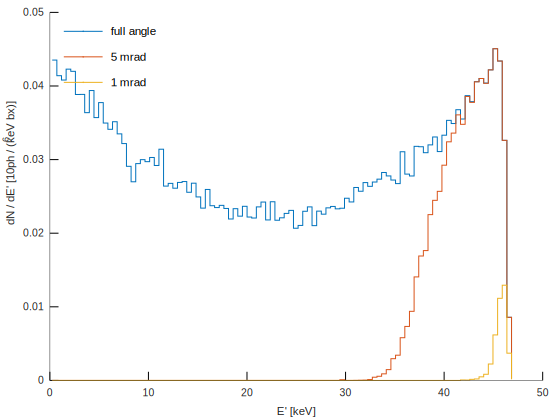

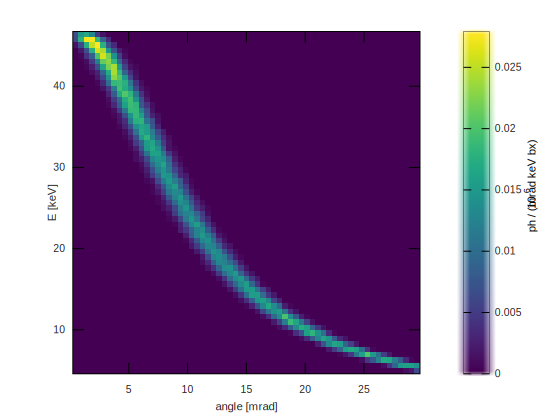

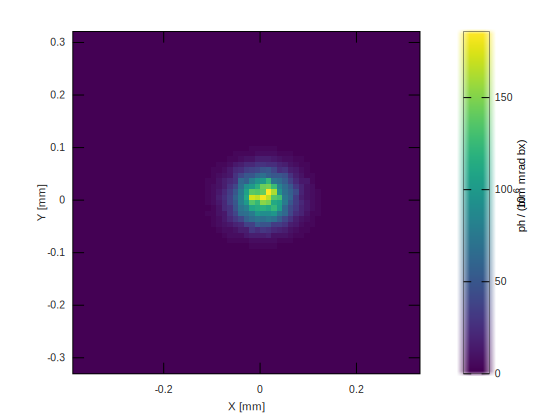

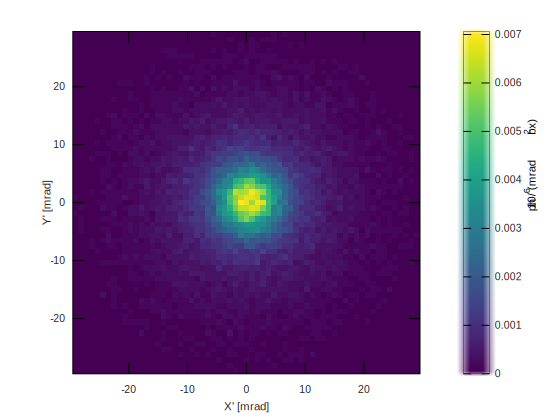

In [13]:
% figure 1
figure
hold on

angle = acos(P1(:,9)) * 1e3; % mrad

[H,X] = whist(P1(:,6) * 1e3, P1(:,8), 100);
H /= X(2)-X(1); 
stairs(X,H/1e6, 'linewidth', 1)
[H,X] = whist(P1(angle<5,6) * 1e3, P1(angle<5,8), X);
H /= X(2)-X(1); 
stairs(X,H/1e6, 'linewidth', 1)
[H,X] = whist(P1(angle<1,6) * 1e3, P1(angle<1,8), X);
H /= X(2)-X(1); 
stairs(X,H/1e6, 'linewidth', 1)
xlabel('E'' [keV]');
ylabel('dN / dE'' [10^6 ph / (keV bx)]');
h = legend('full angle', '5 mrad', '1 mrad');
legend (h, 'location', 'northwest');
legend boxoff;
set(gca, 'fontsize', 8)

% cut large-angle photons
P1(angle>30,:) = [];
angle(angle>30) = [];

% figure 2
figure
[H,Xa,Ya] = whist2d([ angle P1(:,6)*1e3 ], P1(:,8), 64, 64, Nw_RFT / 1e6);
H /= (Xa(2) - Xa(1)) * (Ya(2) - Ya(1));
h = pcolor(Xa,Ya,H);
set(h, 'EdgeColor', 'none');
axis([ Xa(1) Xa(end) Ya(1) Ya(end) ]);
xlabel('angle [mrad]');
ylabel('E [keV]');
h = colorbar;
set(h, 'fontsize', 8);
set(get(h,'label'),'string','10^6 ph / (mrad keV bx)','fontsize', 8);
set(gca, 'fontsize', 8);

% figure 3
figure
[H,Xa,Ya] = whist2d(P1(:,[ 1 3 ]), P1(:,8), 64, 64, Nw_RFT / 1e6);
H /= (Xa(2) - Xa(1)) * (Ya(2) - Ya(1));
h = pcolor(Xa,Ya,H);
set(h, 'EdgeColor', 'none');
axis([ Xa(1) Xa(end) Ya(1) Ya(end) ]);
xlabel('X [mm]');
ylabel('Y [mm]');
h = colorbar;
set(h, 'fontsize', 8);
set(get(h,'label'),'string','10^6 ph / (mm mrad bx)','fontsize', 8);
set(gca, 'fontsize', 8);

% figure 4
figure
[H,Xa,Ya] = whist2d(P1(:,[ 2 4 ]), P1(:,8), 64, 64, Nw_RFT / 1e6);
H /= (Xa(2) - Xa(1)) * (Ya(2) - Ya(1));
h = pcolor(Xa,Ya,H);
set(h, 'EdgeColor', 'none');
axis([ Xa(1) Xa(end) Ya(1) Ya(end) ]);
xlabel('X'' [mrad]');
ylabel('Y'' [mrad]');
h = colorbar;
set(h, 'fontsize', 8);
set(get(h, 'label'), 'string','10^6 ph / (mrad^2 bx)','fontsize', 8);
set(gca, 'fontsize', 8);


### Scan of beta star
Depending on the electron beam and on the laser properties, the optimal $\beta^\star$ (beta function at the IP) might not be the smallest possible. A beta scan will show this.

In [14]:
X_angle = 2; % deg, crossing angle

Nw = [];

for IP_beta = [ 0.001 0.005 0.01 0.05 0.1 0.5 ] % m, beta star

    %% Define Twiss parameters
    Twiss = Bunch6d_twiss();
    Twiss.emitt_x = 1; % mm.mrad, normalized emittances
    Twiss.emitt_y = 1; % mm.mrad
    Twiss.beta_x = IP_beta + IP_Lstar^2 / IP_beta; % m
    Twiss.beta_y = IP_beta + IP_Lstar^2 / IP_beta; % m
    Twiss.alpha_x = IP_Lstar / IP_beta; % converging beam
    Twiss.alpha_y = IP_Lstar / IP_beta; %
    Twiss.sigma_t = sigma_t; % mm/c
    Twiss.sigma_pt = Pspread; % permille
    
    %% Create the bunch
    B0 = Bunch6d(RF_Track.electronmass, Q_pC*RF_Track.pC, -1, Pref, Twiss, 10000);

    LB = LaserBeam(); % Fabry-Pérot resonator
    LB.pulse_energy = 100; % mJ, laser pulse energy
    LB.pulse_length = 0.5; % ps, laser pulse length
    LB.wavelength = 1030; % nm, laser wavelength
    LB.set_direction ( sind(180-X_angle), 0, cosd(180-X_angle)); % 2 degrees crossing angle
    LB.length = L_IP;
    LB.set_position(IP_Lstar); % m
    LB.R = B0.get_info().sigma_x; % mm, laser rms radius at waist, Gaussian profile
    LB.M2 = 1.1; %
    LB.min_number_of_gammas_per_slice = 8;
    LB.set_nsteps(100);

    L = Lattice();
    L.append (LB);

    tic
    B1 = L.track(B0);
    toc
    
    % Separate photons from electrons
    M1 = B1.get_phase_space('%x %xp %y %yp %t %Pc %m %N %Vz');
    M1_w = M1(:,7)==0.0; % pick the photons
    E1 = M1(~M1_w,:); % electrons
    P1 = M1( M1_w,:); % photons

    angle = acos(P1(:,9)) * 1e3; % mrad

    Nw_RFT_1mrad = sum(P1(angle<1,8))
    Nw_RFT_5mrad = sum(P1(angle<5,8))

    disp('')

    Nw = [ Nw ; IP_beta Nw_RFT_1mrad Nw_RFT_5mrad ];
end

Elapsed time is 3.67166 seconds.
Nw_RFT_1mrad = 9.6849e+05
Nw_RFT_5mrad = 2.1026e+07

Elapsed time is 3.70839 seconds.
Nw_RFT_1mrad = 1.1603e+06
Nw_RFT_5mrad = 2.2154e+07

Elapsed time is 3.77103 seconds.
Nw_RFT_1mrad = 9.9349e+05
Nw_RFT_5mrad = 1.7388e+07

Elapsed time is 3.86913 seconds.
Nw_RFT_1mrad = 3.5032e+05
Nw_RFT_5mrad = 6.1186e+06

Elapsed time is 3.56729 seconds.
Nw_RFT_1mrad = 1.9957e+05
Nw_RFT_5mrad = 3.4995e+06

Elapsed time is 3.85722 seconds.
Nw_RFT_1mrad = 4.4760e+04
Nw_RFT_5mrad = 7.7477e+05



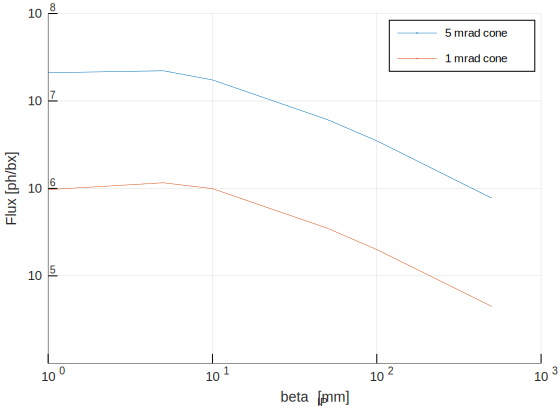

In [15]:
hold on
loglog(Nw(:,1)*1e3, Nw(:,3));
loglog(Nw(:,1)*1e3, Nw(:,2));
xlabel('beta_{IP} [mm]')
ylabel('Flux [ph/bx]')
legend({ '5 mrad cone', '1 mrad cone' });
grid on